In [1]:
# 匯入必要模組
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import learning_curve
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# Preprocessing

In [3]:
import pandas as pd

# 讀取新上傳的清理後資料檔案
df = pd.read_csv("./zomato_combined.csv")

# 刪除 multiple_deliveries 欄位為空值的 row
df_cleaned = df.dropna(subset=['multiple_deliveries'])

# 刪除 Festival 欄位為 "Yes" 或 空值的 row
df_cleaned = df_cleaned[~((df_cleaned['Festival'] == 'Yes') | (df_cleaned['Festival'].isna()))]

# 檢查目前是否還有任何欄位包含空值
missing_summary = df_cleaned.isna().sum()
missing_summary

Delivery_person_Age            0
Delivery_person_Ratings        0
Restaurant_latitude            0
Restaurant_longitude           0
Delivery_location_latitude     0
Delivery_location_longitude    0
Order_Date                     0
Time_Orderd                    0
Time_Order_picked              0
Weather_conditions             0
Road_traffic_density           0
Type_of_order                  0
Type_of_vehicle                0
multiple_deliveries            0
Festival                       0
City                           0
Time_taken (min)               0
order_datetime                 0
distance_km                    0
Estimated_duration_minutes     0
dtype: int64

In [4]:
# 建立 delayed 欄位：若 Time_taken (min) > Estimated_duration_minutes 則為 1，否則為 0
df_cleaned['delayed'] = (df_cleaned['Time_taken (min)'] > df_cleaned['Estimated_duration_minutes']).astype(int)
df_cleaned.head(5)

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,...,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min),order_datetime,distance_km,Estimated_duration_minutes,delayed
0,36.0,4.2,30.327968,78.046106,30.397968,78.116106,12-02-2022,21:55,22:10,Fog,...,Snack,motorcycle,3.0,No,Metropolitian,46,2022-02-12 21:55:00,10.280582,46,0
1,21.0,4.7,10.003064,76.307589,10.043064,76.347589,13-02-2022,14:55,15:05,Stormy,...,Meal,motorcycle,1.0,No,Metropolitian,23,2022-02-13 14:55:00,6.242319,24,0
2,23.0,4.7,18.562450,73.916619,18.652450,74.006619,04-03-2022,17:30,17:40,Sandstorms,...,Drinks,scooter,1.0,No,Metropolitian,21,2022-03-04 17:30:00,13.787860,42,0
3,34.0,4.3,30.899584,75.809346,30.919584,75.829346,13-02-2022,09:20,09:30,Sandstorms,...,Buffet,motorcycle,0.0,No,Metropolitian,20,2022-02-13 09:20:00,2.930258,15,1
4,24.0,4.7,26.463504,80.372929,26.593504,80.502929,14-02-2022,19:50,20:05,Fog,...,Snack,scooter,1.0,No,Metropolitian,41,2022-02-14 19:50:00,19.396618,55,0


In [8]:
# 建立特徵欄位（移除延遲定義用的欄位）
X = df_cleaned.drop(columns=['delayed', 'order_datetime', 'Time_taken (min)', 'Estimated_duration_minutes'])
y = df_cleaned['delayed']

# 時間欄位轉換與萃取特徵
X['Order_Date'] = pd.to_datetime(X['Order_Date'], format='%d-%m-%Y')
X['hour_ordered'] = pd.to_datetime(df_cleaned['Time_Orderd'], format='%H:%M', errors='coerce').dt.hour
X['hour_picked'] = pd.to_datetime(df_cleaned['Time_Order_picked'], format='%H:%M', errors='coerce').dt.hour
X['day_of_week'] = X['Order_Date'].dt.dayofweek.astype('category')

# 時段分類（自訂分類）
def assign_time_segment(hour):
    if pd.isnull(hour):
        return 'unknown'
    elif 8 <= hour <= 11:
        return 'morning_noon'
    elif 12 <= hour <= 16:
        return 'afternoon'
    elif hour >= 17:
        return 'evening'
    else:
        return 'other'

X['time_segment'] = X['hour_ordered'].apply(assign_time_segment)

# 移除原始時間欄位
X = X.drop(columns=['Time_Orderd', 'Time_Order_picked'])

# 特徵分類
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category', 'datetime64']).columns.tolist()

# 建立前處理器
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [10]:
X_transformed = preprocessor.fit_transform(X)
print("處理後資料維度:", X_transformed.shape)

處理後資料維度: (38835, 84)


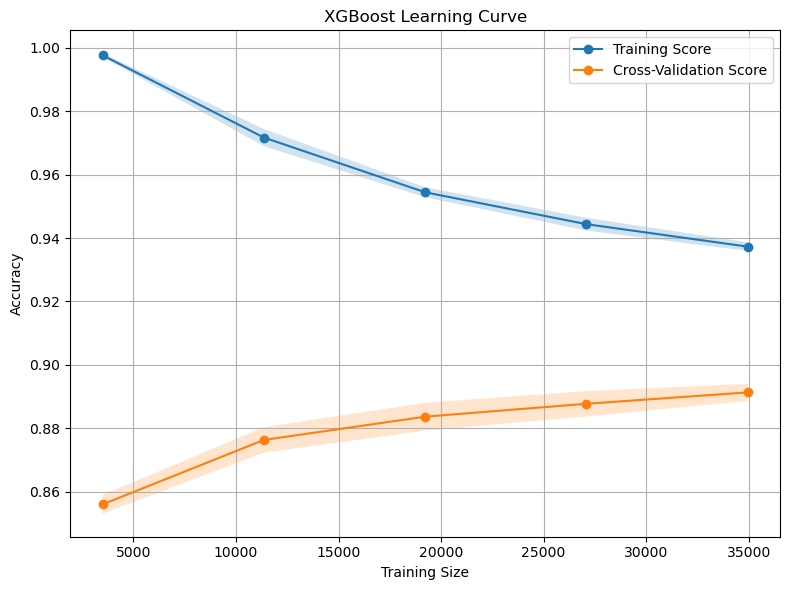

In [12]:
def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=10,
                        scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure(figsize=(8, 6))
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes, n_jobs=-1
    )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, 'o-', label="Training Score")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
    plt.plot(train_sizes, test_mean, 'o-', label="Cross-Validation Score")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel(scoring.capitalize())
    plt.legend(loc="best")
    plt.grid()
    plt.tight_layout()
    plt.show()

# 建立模型與交叉驗證策略
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 放入學習曲線函數
plot_learning_curve(
    estimator=XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    X=X_transformed,
    y=y,
    title="XGBoost Learning Curve",
    cv=10,
    scoring='accuracy'
)

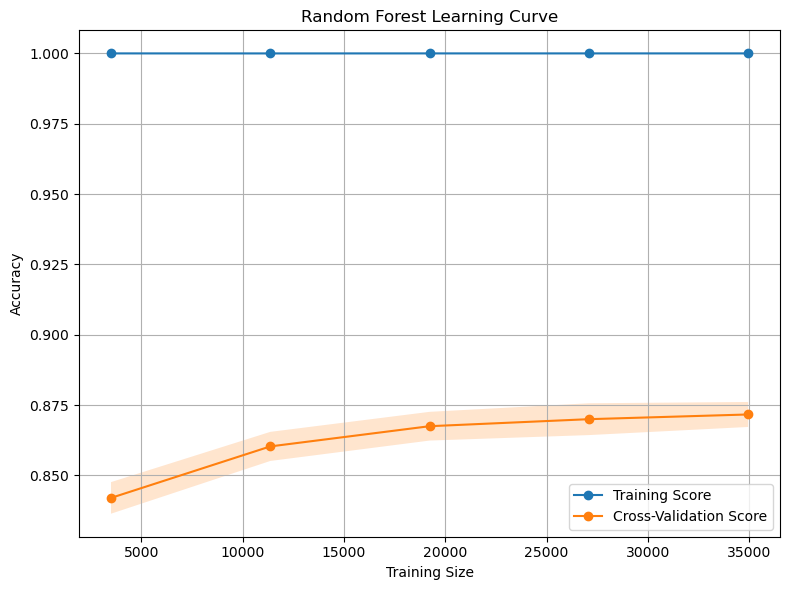

In [13]:
# 放入學習曲線函數_RandomForest
plot_learning_curve(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    X=X_transformed,
    y=y,
    title="Random Forest Learning Curve",
    cv=10, 
    scoring='accuracy'
)